In [1]:
import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import csv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.pylab as plt
import math
import collections
import heapq

In [2]:
# load Facebook data from online source
url = "https://us8.mailchimp.com/mctx/clicks?url=https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fdocuments.thinknum.com%2Fdataset_dump%2Fgnhsjbgeza%2Ftemp_datalab_records_social_facebook.zip&h=f84203f1bc203108cdcb47ef0284e06a4070047f8c79865765f0128abc579fa2&v=1&xid=2a067544d1&uid=29791003&pool=contact_facing&subject=Here%27s+your+data+sets+from+The+Data+Incubator+and+Thinknum"
resp = urlopen(url)
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()
fb = pd.read_csv(zipfile.open('temp_datalab_records_social_facebook.csv'))
zipfile.close()

D:\Python\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
fb.head()

,dataset_id,time,username,checkins,has_added_app,were_here_count,likes,talking_about_count,facebook_id,date_added,date_updated,entity_id,cusip,isin
0,53088,2015-01-01 05:00:00+00,SodaStream,0,f,0,761533,587,54885616308,NaN,2017-02-14 03:35:13.236826+00,NaN,NaN,NaN
1,52642,2015-01-01 05:00:00+00,ANSYSInc,148,f,0,43442,1305,160242297413411,NaN,2017-02-14 01:55:52.78506+00,NaN,NaN,NaN
2,53656,2015-01-01 05:00:00+00,MyAquaAmerica,0,f,0,5591,297,591693544195818,NaN,2017-02-14 08:13:51.267343+00,NaN,NaN,NaN
3,53033,2015-01-01 05:00:00+00,Qualcomm,173,f,0,1232521,2685,108472637291,NaN,2017-02-14 03:24:04.363035+00,NaN,NaN,NaN
4,52783,2015-01-01 05:00:00+00,eaglepharmaceuticals,0,f,0,18,0,1428265940729350,NaN,2017-02-14 02:22:10.193588+00,NaN,NaN,NaN


In [4]:
fb.shape

(3621391, 14)

In [5]:
for col in fb.columns:
    print(f"column '{col}' has {fb[col].unique().size} unique values")

column 'dataset_id' has 4714 unique values
column 'time' has 1241 unique values
column 'username' has 4951 unique values
column 'checkins' has 117065 unique values
column 'has_added_app' has 1 unique values
column 'were_here_count' has 244669 unique values
column 'likes' has 926145 unique values
column 'talking_about_count' has 134589 unique values
column 'facebook_id' has 4714 unique values
column 'date_added' has 2090861 unique values
column 'date_updated' has 3611782 unique values
column 'entity_id' has 1 unique values
column 'cusip' has 1 unique values
column 'isin' has 1 unique values


In [6]:
# select columns which we are going to use
fb_reduce = fb[['dataset_id', 'time', 'username', 'likes', 'talking_about_count', 'facebook_id']]

In [7]:
# notice that 'dataset_id' and 'facebook_id' have exactly the same unique values
# let's furthur verify that they are exactly paired with each other
pair = {}
for dataset_id, curr_df in fb_reduce.groupby('dataset_id', sort = False):
    pair[dataset_id] = curr_df['facebook_id'].iloc[0]
fb_reduce[fb_reduce['dataset_id'].map(pair) != fb_reduce['facebook_id']]['dataset_id'].size

0

In [8]:
# because 'dataset_id' and 'facebook_id' are exactly paired, let's drop column 'facebook_id'
fb_reduce.drop(columns = ['facebook_id'], inplace = True)

D:\Python\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
# observe that 'username' is the only column that has 'NaN' values
for col in fb_reduce.columns:
    n_nan = fb_reduce[fb_reduce[col].isna()][col].size
    if n_nan > 0:
        print(f"column '{col}' has {n_nan} 'NaN' values")

column 'username' has 120929 'NaN' values


In [10]:
# find invalid dataset_id whose all usernames are missing
# pair each valid dataset_id with a list of its usernames
invalid_dataset_id = []
id_user_map = {}
#print("dataset_id with multiple usernames:")
for dataset_id, curr_df in fb_reduce.groupby('dataset_id', sort = False):
    curr_df = curr_df[curr_df['username'].isna() == False]
    if curr_df.size == 0:
        invalid_dataset_id.append(dataset_id)
    else:
        curr_username = curr_df['username'].unique()
#        if curr_username.size > 1:
#            print(dataset_id, list(curr_username))
        id_user_map[dataset_id] = list(curr_username)[-1]

In [11]:
print(f"there are {len(invalid_dataset_id)} invalid dataset_id's whose all usernames are missing")

there are 132 invalid dataset_id's whose all usernames are missing


In [12]:
# observe there're many cases that one dataset_id is corresponding to several username
# mostly it's because one same company used multiple names
# drop those rows with invalid dataset_id
fb_reduce.dropna(inplace = True)

D:\Python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [13]:
# drop column 'username', will use hashmap id_user_map instead
fb_reduce.drop(columns = ['username'], inplace = True)

In [14]:
# Obeserve 'dataset_id' 63328 and 63329 both refer to McDonalds
id_user_map[63328], id_user_map[63329]

('McDonaldsUS', 'McDonalds')

In [15]:
# replace all 63328 by 63329
fb_reduce.replace({'dataset_id': 63328}, 63329, inplace = True)

D:\Python\lib\site-packages\pandas\core\frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [16]:
fb_reduce['time'] = pd.to_datetime(fb_reduce['time'])
print(f"time stamp is from {fb_reduce['time'].min()} to {fb_reduce['time'].max()}")
print(f"there are in total {fb_reduce['time'].unique().size} days in record")

time stamp is from 2015-01-01 05:00:00+00:00 to 2018-07-17 04:00:00+00:00
there are in total 1241 days in record


D:\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
#fb_reduce.head()

In [18]:
# observe that every row has a positive 'likes' number
fb_reduce[fb_reduce['likes'] == 0]['likes'].size

0

In [19]:
# create dataframe tac_likes_df
id_user_tac_likes_ratio = []

for curr_id, curr_df in fb_reduce.groupby('dataset_id', sort = False):
    curr_user = id_user_map[curr_id]
    days = (curr_df['time'].max() - curr_df['time'].min()).days + 1
    curr_tac_mean = round(curr_df['talking_about_count'].sum() / days)
    curr_likes_mean = round(curr_df['likes'].sum() / days)
    curr_ratio_df = curr_df['talking_about_count'] / curr_df['likes']
    curr_ratio_mean = round(curr_ratio_df.sum() / days, 6)
    id_user_tac_likes_ratio.append((curr_id, curr_user, int(curr_tac_mean), int(curr_likes_mean), curr_ratio_mean)) 

tac_likes_df = pd.DataFrame(id_user_tac_likes_ratio, columns = ['dataset_id', 'username', 'tac_mean', 'likes_mean', 'tac_over_likes_ratio_mean'])

In [20]:
tac_likes_df.shape

(4581, 5)

In [21]:
# dataframe tac_likes_df captures those companies, either in top 100 tac_mean list, or in top 100 likes_mean list
tac_likes_df.sort_values(by='tac_mean', ascending=False, inplace = True)
id_set = set(set(tac_likes_df['dataset_id'].iloc[:100]))
tac_likes_df.sort_values(by='likes_mean', ascending=False, inplace = True)
id_set = id_set.union(set(tac_likes_df['dataset_id'].iloc[:100]))
tac_likes_reduce = pd.concat([tac_likes_df[tac_likes_df['dataset_id'] == x] for x in id_set])

In [22]:
# there are 158 such companies
# this means 42 companies are in both top 100 tac_mean and top 100 likes_mean lists
tac_likes_reduce.shape

(158, 5)

In [23]:
def plot_tac(curr_id):
    fig, ax = plt.subplots(figsize = (20,7))
    
    curr_df = fb_reduce[fb_reduce['dataset_id'] == curr_id]
    ax.plot(curr_df['time'], curr_df['talking_about_count'], label = id_user_map[curr_id])
        
    ax.set(xlabel='time', title = 'tac_mean')
    ax.grid()
    plt.legend()
    plt.show()
    print('\n')

def plot_likes(curr_id):
    fig, ax = plt.subplots(figsize = (20,7))
    
    curr_df = fb_reduce[fb_reduce['dataset_id'] == curr_id]
    ax.plot(curr_df['time'], curr_df['likes'], label = id_user_map[curr_id])
        
    ax.set(xlabel='time', title = 'likes_mean')
    ax.grid()
    plt.legend()
    plt.show()
    print('\n')

def plot_ratio(curr_id):
    fig, ax = plt.subplots(figsize = (20,7))
    
    curr_df = fb_reduce[fb_reduce['dataset_id'] == curr_id]
    ax.plot(curr_df['time'], curr_df['talking_about_count'] / curr_df['likes'], label = id_user_map[curr_id])
        
    ax.set(xlabel='time', title = 'tac_over_likes_ratio_mean')
    ax.grid()
    plt.legend()
    plt.show()
    print('\n')

In [24]:
# top 20 companies in 'tac_mean'
tac_likes_reduce.sort_values(by='tac_mean', ascending=False, inplace = True)
print("top 20 companies in 'tac_mean'")
tac_likes_reduce.head(20)

top 20 companies in 'tac_mean'


,dataset_id,username,tac_mean,likes_mean,tac_over_likes_ratio_mean
496,53470,manchesterunited,1555581,66589285,0.022361
1728,63359,nytimes,1194144,12564732,0.091844
557,53657,wwe,1184840,29665911,0.036284
2841,868421,CBSNews,981925,3922076,0.238345
1494,61368,usatoday,801433,7049166,0.113647
1040,57603,CollegeHumor,796045,6710444,0.112073
966,56003,ESPN,738405,15383892,0.045995
2883,869047,Storyful,702768,2294683,0.360262
1001,56677,yahoo,617366,12959805,0.044807
988,56198,netflix,471246,28867149,0.013267


In [25]:
print("top 20 companies in 'tac_mean'")
print(list(tac_likes_reduce.iloc[:20]['username']))

top 20 companies in 'tac_mean'
['manchesterunited', 'nytimes', 'wwe', 'CBSNews', 'usatoday', 'CollegeHumor', 'ESPN', 'Storyful', 'yahoo', 'netflix', 'NYPost', 'foxdeportes', 'AntennaTV', 'thesun', 'CBSSports', 'WGNTV', 'facebook', 'foxsports', 'BET', 'Disney']


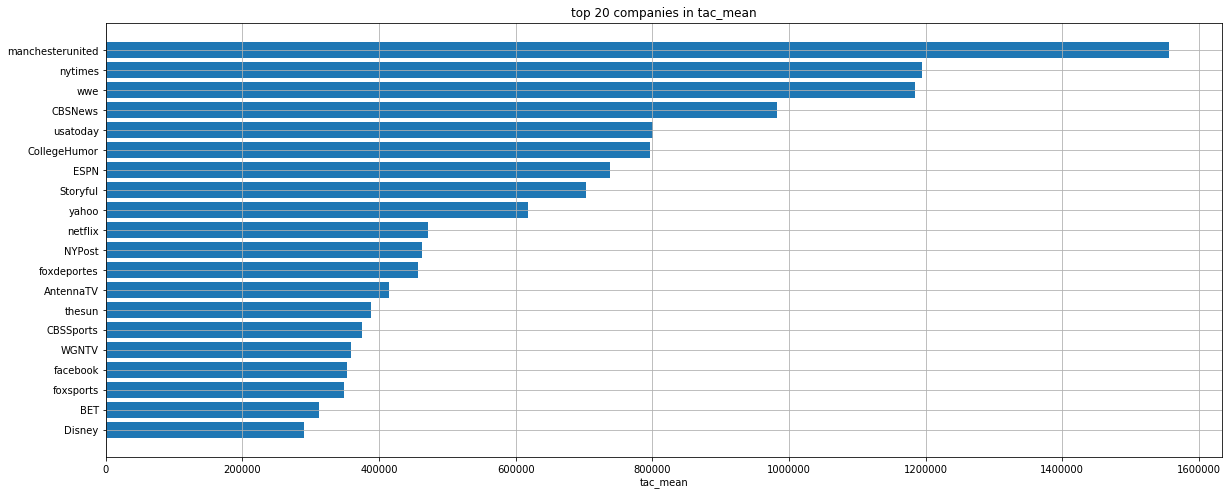

In [26]:
fig, ax = plt.subplots(figsize = (20,8))
curr_df = tac_likes_reduce.iloc[:20][::-1]
ax.barh(curr_df['username'], curr_df['tac_mean'])
ax.set(xlabel= 'tac_mean', title= 'top 20 companies in tac_mean')
    
ax.grid()
plt.show()
print('\n')

In [27]:
# top 20 companies in 'likes_mean'
tac_likes_reduce.sort_values(by='likes_mean', ascending=False, inplace = True)
print("top 20 companies in 'likes_mean'")
tac_likes_reduce.head(20)

top 20 companies in 'likes_mean'


,dataset_id,username,tac_mean,likes_mean,tac_over_likes_ratio_mean
982,56196,facebook,353415,175168835,0.001936
1745,63329,McDonalds,70011,132392688,0.001005
1601,62291,youtube,174655,78459190,0.002122
496,53470,manchesterunited,1555581,66589285,0.022361
2354,69295,natgeotvUS,86719,56644731,0.001471
909,55669,Disney,290857,48478669,0.005735
1936,64359,KFC,34257,42773805,0.000791
3050,871651,Starbucks,268178,34520156,0.007285
3075,878839,PepsiUS,26022,34455243,0.000707
76,52612,walmart,118501,31373107,0.003550


In [28]:
print("top 20 companies in 'likes_mean'")
print(list(tac_likes_reduce.iloc[:20]['username']))

top 20 companies in 'likes_mean'
['facebook', 'McDonalds', 'youtube', 'manchesterunited', 'natgeotvUS', 'Disney', 'KFC', 'Starbucks', 'PepsiUS', 'walmart', 'wwe', 'iTunes', 'netflix', 'PizzaHut', 'Intel', 'kscleanmaster', 'Skype', 'victoriassecret', 'Amazon', 'Marvel']


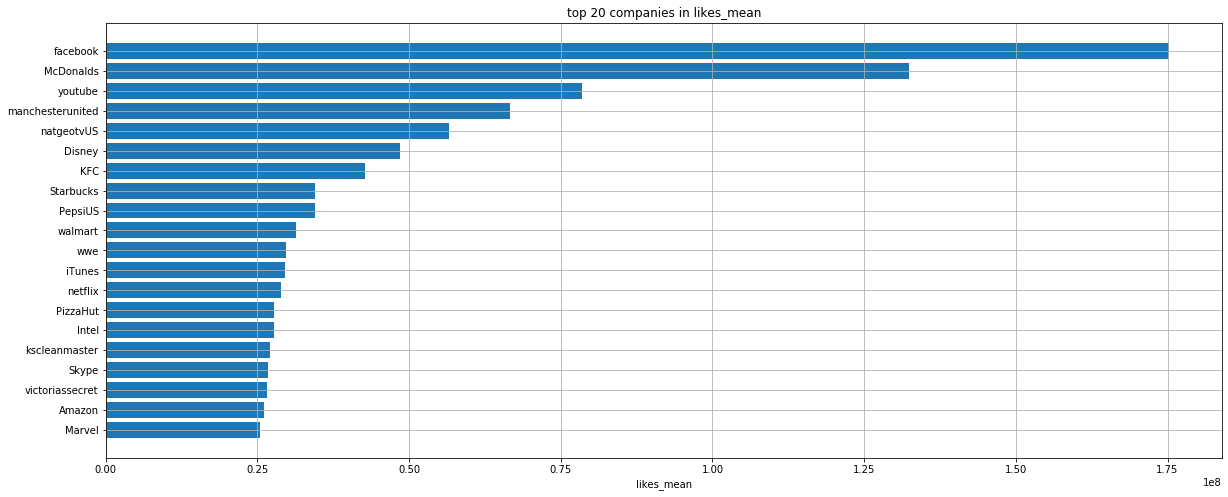

In [29]:
fig, ax = plt.subplots(figsize = (20,8))
curr_df = tac_likes_reduce.iloc[:20][::-1]
ax.barh(curr_df['username'], curr_df['likes_mean'])
ax.set(xlabel= 'likes_mean', title= 'top 20 companies in likes_mean')
    
ax.grid()
plt.show()
print('\n')

In [30]:
# top 20 companies in 'tac_over_likes_ratio_mean'
tac_likes_reduce.sort_values(by='tac_over_likes_ratio_mean', ascending=False, inplace = True)
print("top 20 companies in 'tac_over_likes_ratio_mean'")
tac_likes_reduce.head(20)

top 20 companies in 'tac_over_likes_ratio_mean'


,dataset_id,username,tac_mean,likes_mean,tac_over_likes_ratio_mean
2608,70151,WGNTV,359155,777664,0.486827
1403,60883,tricolor1035,176049,443362,0.470032
2473,70141,AntennaTV,414420,1040762,0.416247
2636,70136,fox6news,123332,315724,0.370599
2623,70162,wreg3,100153,277779,0.362663
2640,70154,Q13FOX,149539,416490,0.361802
2883,869047,Storyful,702768,2294683,0.360262
1522,61441,WJXT4TheLocalStation,114540,323251,0.354792
2577,70160,fox31denver,115744,323380,0.348035
1451,61329,detroitfreepress,118761,345505,0.333217


In [31]:
print("top 20 companies in 'tac_over_likes_ratio_mean'")
print(list(tac_likes_reduce.iloc[:20]['username']))

top 20 companies in 'tac_over_likes_ratio_mean'
['WGNTV', 'tricolor1035', 'AntennaTV', 'fox6news', 'wreg3', 'Q13FOX', 'Storyful', 'WJXT4TheLocalStation', 'fox31denver', 'detroitfreepress', 'fox5sandiego', 'Local4', 'pix11news', 'Fox59News', 'WTKR3', 'CBS6News', 'Fox8NewsCleveland', 'fox8news', 'azcentral', 'KSAT12']


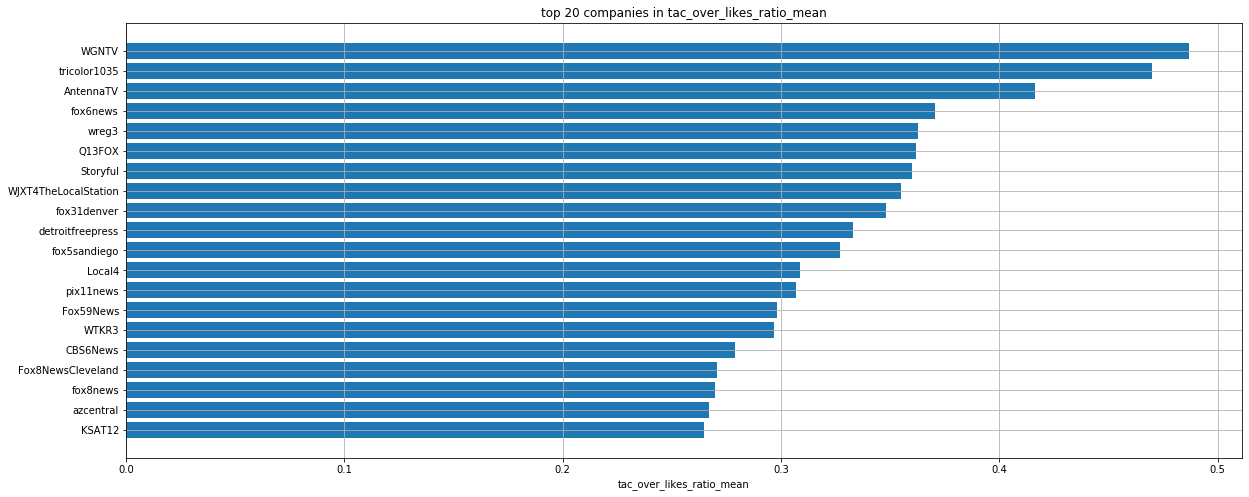

In [32]:
fig, ax = plt.subplots(figsize = (20,8))
curr_df = tac_likes_reduce.iloc[:20][::-1]
ax.barh(curr_df['username'], curr_df['tac_over_likes_ratio_mean'])
ax.set(xlabel= 'tac_over_likes_ratio_mean', title= 'top 20 companies in tac_over_likes_ratio_mean')
    
ax.grid()
plt.show()
print('\n')

In [33]:
# bottom 20 companies in 'tac_over_likes_ratio_mean'
tac_likes_reduce.sort_values(by='tac_over_likes_ratio_mean', inplace = True)
print("bottom 20 companies in 'tac_over_likes_ratio_mean'")
tac_likes_reduce.head(20)

bottom 20 companies in 'tac_over_likes_ratio_mean'


,dataset_id,username,tac_mean,likes_mean,tac_over_likes_ratio_mean
1028,57202,StellaArtoisSingapore,31,7707607,0.000004
4079,931671,johnsonsbaby,231,11113013,0.000019
3920,911355,headandshouldersusa,856,8881935,0.000088
1014,57117,DunkinDonuts,2134,13601931,0.000154
1937,64360,PizzaHut,4569,27751645,0.000158
3884,911362,headandshoulders,1842,8881955,0.000189
3918,911327,Pampers,6915,16202296,0.000394
3078,878838,DoritosUSA,7778,15532218,0.000470
2082,65871,HeladosHolanda,3801,7664443,0.000486
1684,62862,MastercardUS,7801,14009949,0.000525


In [34]:
print("bottom 20 companies in 'tac_over_likes_ratio_mean'")
print(list(tac_likes_reduce.iloc[:20]['username']))

bottom 20 companies in 'tac_over_likes_ratio_mean'
['StellaArtoisSingapore', 'johnsonsbaby', 'headandshouldersusa', 'DunkinDonuts', 'PizzaHut', 'headandshoulders', 'Pampers', 'DoritosUSA', 'HeladosHolanda', 'MastercardUS', 'BlackBerry', 'PepsiUS', 'Skype', 'iTunes', 'skyscanner', 'KFC', 'Avon', 'McDonalds', 'Paramount', 'Closeup']


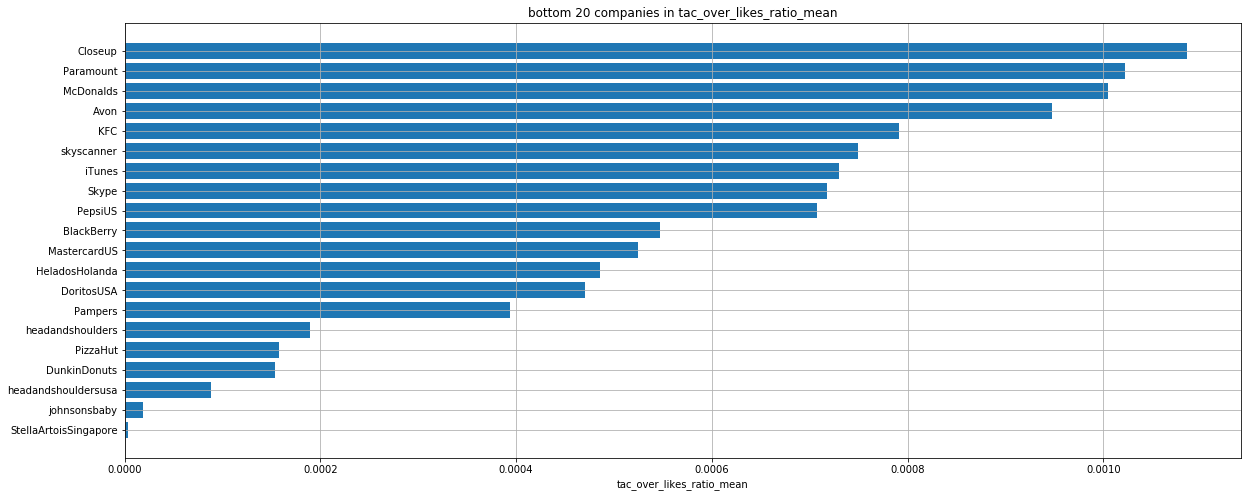

In [35]:
fig, ax = plt.subplots(figsize = (20,8))
curr_df = tac_likes_reduce.iloc[:20]
ax.barh(curr_df['username'], curr_df['tac_over_likes_ratio_mean'])
ax.set(xlabel= 'tac_over_likes_ratio_mean', title= 'bottom 20 companies in tac_over_likes_ratio_mean')
    
ax.grid()
plt.show()
print('\n')

from 2015-07-16 04:00:00+00:00 to 2018-07-16 04:00:00+00:00


D:\Python\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


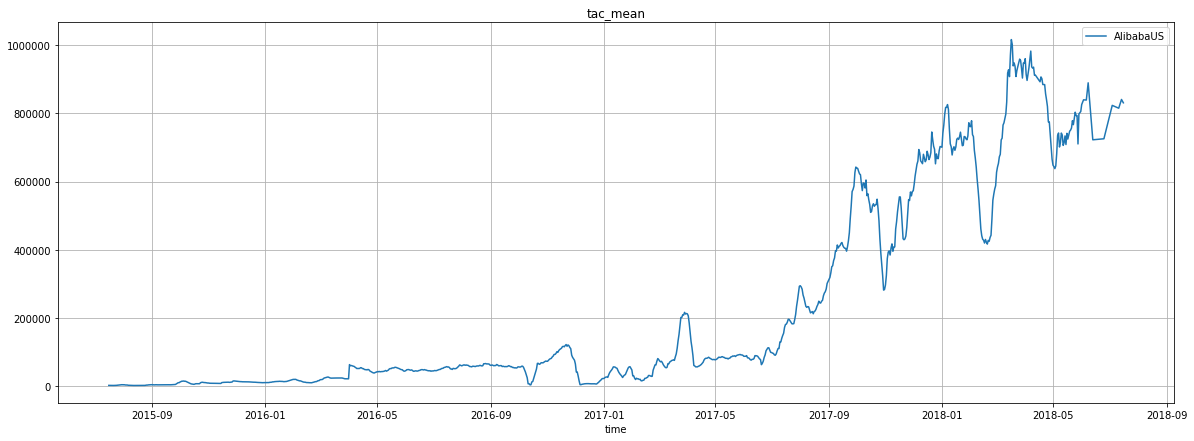

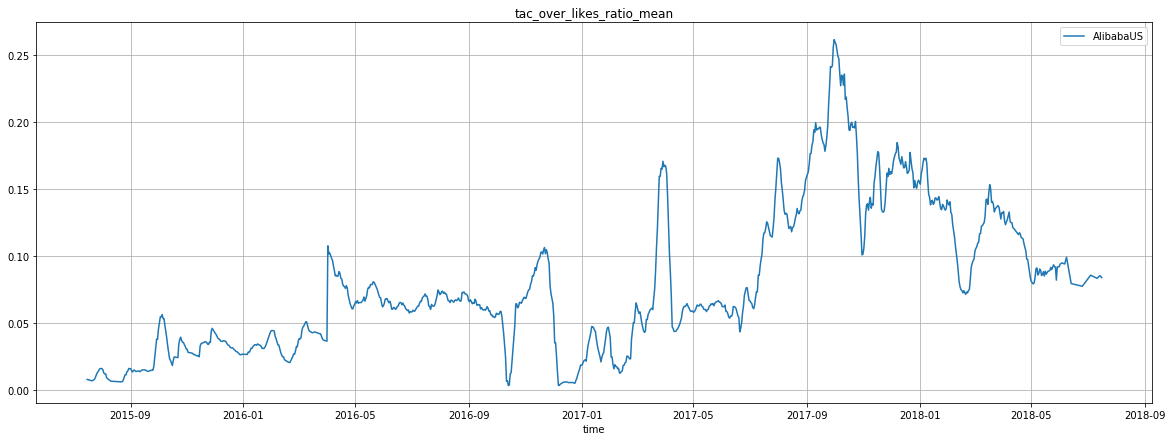

In [36]:
# company AlibabaUS's tac_mean and tac_over_likes_ratio_mean curve coincides a lot with its stock price
# for reference, check the following link for AlibabaUs's stock price in the same time period
# https://finance.yahoo.com/chart/BABA#eyJpbnRlcnZhbCI6IndlZWsiLCJwZXJpb2RpY2l0eSI6MSwiY2FuZGxlV2lkdGgiOjUuODQwNzY0MzMxMjEwMTkxLCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJsaW5lIiwiZXh0ZW5kZWQiOmZhbHNlLCJtYXJrZXRTZXNzaW9ucyI6e30sImFnZ3JlZ2F0aW9uVHlwZSI6Im9obGMiLCJjaGFydFNjYWxlIjoibGluZWFyIiwicGFuZWxzIjp7ImNoYXJ0Ijp7InBlcmNlbnQiOjEsImRpc3BsYXkiOiJCQUJBIiwiY2hhcnROYW1lIjoiY2hhcnQiLCJpbmRleCI6MCwieUF4aXMiOnsibmFtZSI6ImNoYXJ0IiwicG9zaXRpb24iOm51bGx9LCJ5YXhpc0xIUyI6W10sInlheGlzUkhTIjpbImNoYXJ0Iiwi4oCMdm9sIHVuZHLigIwiXX19LCJsaW5lV2lkdGgiOjIsInN0cmlwZWRCYWNrZ3JvdW5kIjp0cnVlLCJldmVudHMiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN0cmlwZWRCYWNrZ3JvdWQiOnRydWUsInJhbmdlIjp7ImR0TGVmdCI6IjIwMTUtMDctMTZUMDc6MDA6MDAuMDAwWiIsImR0UmlnaHQiOiIyMDE4LTA3LTE3VDA2OjU5OjAwLjAwMFoiLCJwZXJpb2RpY2l0eSI6eyJpbnRlcnZhbCI6IndlZWsiLCJwZXJpb2QiOjF9LCJwYWRkaW5nIjowfSwiZXZlbnRNYXAiOnsiY29ycG9yYXRlIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZX0sInNpZ0RldiI6e319LCJjdXN0b21SYW5nZSI6eyJzdGFydCI6MTQzNzM3NTYwMDAwMCwiZW5kIjoxNTMxNzI0NDAwMDAwfSwic3ltYm9scyI6W3sic3ltYm9sIjoiQkFCQSIsInN5bWJvbE9iamVjdCI6eyJzeW1ib2wiOiJCQUJBIiwicXVvdGVUeXBlIjoiRVFVSVRZIiwiZXhjaGFuZ2VUaW1lWm9uZSI6IkFtZXJpY2EvTmV3X1lvcmsifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoid2VlayJ9XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwMGIwNjEiLCJEb3duIFZvbHVtZSI6IiNmZjMzM2EifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsid2lkdGhGYWN0b3IiOjAuNDUsImNoYXJ0TmFtZSI6ImNoYXJ0IiwicGFuZWxOYW1lIjoiY2hhcnQifX19fQ%3D%3D
print(f"from {fb_reduce[fb_reduce['dataset_id'] == 55647]['time'].min()} to {fb_reduce[fb_reduce['dataset_id'] == 55647]['time'].max()}")
plot_tac(55647)
plot_ratio(55647)